In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Create the 4-d u-function as mentioned:

In [2]:
def sigmoid(x, a, b, c, d):
    """
    Returns the sigmoid function f(x) = a/(1 + e^(-(bx - c))) + d 
    
    Parameters are:
    
    a adjusts the minimum and maximum asymptotes of the sigmoidal curve
    b adjusts the steepness of the sigmoidal curve
    c shifts the curve left and right
    d shifts the curve up and down
    
    """
    return a/(1 + np.exp(-(b * x - c))) + d

def neg_exponential(x, a, b, c, d):
    """
    Returns the negative exponential function f(x) = a * e^-bx + c
    
    Parameters are:
    
    a shifts the curve left and right
    b adjusts the steepness of the curve
    c is the horizontal asymptote
    d shifts the curve left and right
    
    """
    return a * np.exp(-b * (x + d)) + c
    

def log_likelihood(params, a_a=0., b_a=1.5, c_a=6., d_a=0., 
                           a_de=0., b_de=1.5, c_de=6., d_de=9.,
                           a_dm=0., b_dm=1.5, c_dm=6., d_dm=9.,
                           a_sa_de=10000., b_sa_de=2., c_sa_de=1.5, d_sa_de=0,
                           a_sa_dm=10000., b_sa_dm=-2, c_sa_dm=1.5, d_sa_dm=-20,
                           a_sde_a=0., b_sde_a=0., c_sde_a=0.2, d_sde_a=0, 
                           a_sdm_a=0., b_sdm_a=0., c_sdm_a=0.2, d_sdm_a=0, 
                           a_theta_de=-1., b_theta_de=1.5, c_theta_de=6., d_theta_de=1., 
                           a_theta_dm=1., b_theta_dm=1.5, c_theta_dm=24., d_theta_dm=0.):
    """
    Negative Log-likelihood function defined below, with the dark energy, dark matter parameters
    
    param params: tuple of 4 numbers omega_a, omega_de, omega_dm, m_a
    """
    omega_a, omega_de, omega_dm, m_a = params  # x is omega_a, y is omega_de, z is omega_dm, w is m_a
    
    # x vector
    x = np.array([omega_a, omega_de, omega_dm])  # x = [omega_a, omega_de, omega_dm] vector
    
    # means in the mu_a and mu_de direction
    # sigmoid curves mu_a(m_a) and mu_de(m_a)
    mu_a = sigmoid(m_a, a_a, b_a, c_a, d_a)  # mu_a = mu_a(m_a) 
    # max(m_a, 10) so if axion mass is high dark energy density parameter is roughly constant
    mu_de = sigmoid(m_a, a_de, b_de, c_de, d_de)  # mu_de = mu_de(m_a) but the sigmoidal curve has different parameters
    # mu_dm should be the same thing as mu_de but in the opposite direction
    mu_dm = sigmoid(m_a, a_dm, b_dm, c_dm, d_dm)  # mu_dm = mu_dm(m_a) but the sigmoidal curve has different parameters
    # mu is a vector of the three
    mu = np.array([mu_a, mu_de, mu_dm])  # mu = [mu_a, mu_de, mu_dm] vector
    
    # covariance matrix C
    # this is how sigma in the a axis changes in the omega_a - omega_de plane
    sigma_a_de = neg_exponential(m_a, a_sa_de, b_sa_de, c_sa_de, d_sa_de)  # variance in a direction: negative exponential curve, sigma_a = sigma_a(m_a, omega_de)
    # this is how sigma in the a axis changes in the omega_a - omega_dm plane
    sigma_a_dm = neg_exponential(m_a, a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm)  # variance in a direction: negative exponential curve, sigma_a = sigma_a(m_a, omega_dm)
    
    # max(m_a, 10) so if axion mass is high dark energy density parameter is roughly constant
    # this is how sigma in the de axis changes in the omega_a - omega_de plane
    sigma_de_a = neg_exponential(m_a, a_sde_a, b_sde_a, c_sde_a, d_sde_a)  # variance in de direction: sigmoid curve, sigma_de = sigma_de(m_a)
    # this is how sigma in the dm axis changes in the omega_a - omega_dm plane
    sigma_dm_a = neg_exponential(m_a, a_sdm_a, b_sdm_a, c_sdm_a, d_sdm_a)  # variance in a direction: negative exponential curve, sigma_dm = sigma_dm(m_a)
    
    # rotating the distribution:
    
    # rotation in the omega_a - omega_de plane (should look sigmoidal 0 < m_a < 10 and then relativley constant 10 < m_a < 20)
    # want to rotate from 45 degrees to 0, so pi/4 -> 0 from 0 to 20
    # also want to elongate along the a axis in the a - de plane
    theta_de = sigmoid(m_a, a_theta_de * -np.pi/4, b_theta_de, c_theta_de, d_theta_de * -np.pi/4)  # covariance: sigmoid curve, g = g(m_a)
    
    # rotation in the omega_a - omega_dm plane (should look relatively constant (0 < m_a < 10 and then sigmoidal 10 < m_a < 20)
    # want to rotate from 0 to 45 degrees, so 0 -> pi/4 from 0 to 20
    # also want to elongate along the a axis in the a - dm plane
    theta_dm = sigmoid(m_a, a_theta_dm * -np.pi/4, b_theta_dm, c_theta_dm, d_theta_dm * -np.pi/4) # covariance: sigmoid curve, g = g(m_a)
    
    # covariance and rotation matrices:
    # covariance matrix: no covariance to start before applying rotations 
    # adding them based on the justification in the graph shown below, 
    # could do piecewise for slightly more accuracy if it's not too much slower
    C = np.array(([sigma_a_de + sigma_a_dm, 0, 0],   # C = [[sigma_a_de + sigma_a_dm, 0, 0], [0, sigma_de_a, 0], [0, 0, sigma_dm_a]]
                  [0, sigma_de_a, 0],  # a = x, de = y, dm = z
                  [0, 0, sigma_dm_a]))
    # rotation matrices
    # rotation in the omega_a - omega_de (xy) plane, so rotation about the z-axis (Rz)
    rot_de = np.array(([np.cos(theta_de), -np.sin(theta_de), 0], 
                       [np.sin(theta_de), np.cos(theta_de), 0], 
                       [0, 0, 1]))
    # rotation in the omega_a - omega_dm (xz) plane, so rotation about the y-axis (Ry)
    rot_dm = np.array(([np.cos(theta_dm), 0, np.sin(theta_dm)], 
                       [0, 1, 0], 
                       [-np.sin(theta_dm), 0, np.cos(theta_dm)]))
    # final rotation matrix is the composition R = R_z R_y
    rot = rot_de @ rot_dm
    
    # return 3d gaussian, applying the appropriate rotation to the covariance matrix
    f = np.exp(-((x - mu).T @ np.linalg.inv(rot @ C @ rot.T) @ (x - mu)))  # general expression for a 2D Gaussian
    
    return f
    

Plot all the curves to make sure the function behaviour is working as intended:

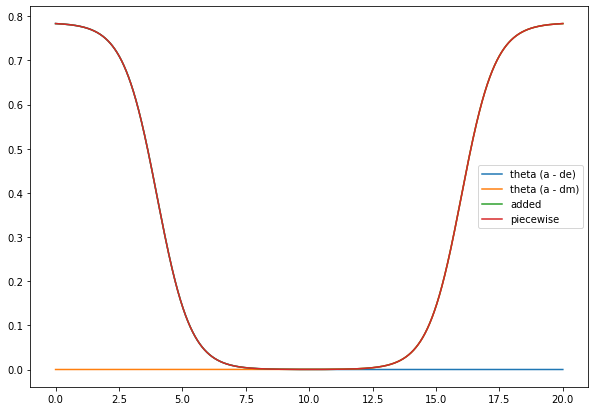

In [3]:
%matplotlib inline

# this shows theta, or how the distribution will rotate, for the a - de and a - dm planes
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=-1 * np.pi/4, b=1.5, c=6, d=1 * np.pi/4), label = 'theta (a - de)')
plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=1 * np.pi/4, b=1.5, c=24, d=0 * np.pi/4), label = 'theta (a - dm)')
# combined to make the full sigma_a

plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=-1 * np.pi/4, b=1.5, c=6, d=1 * np.pi/4) + sigmoid(np.linspace(0, 20, int(1e4)), a=1 * np.pi/4, b=1.5, c=24, d=0 * np.pi/4), label = 'added')
plt.plot(np.linspace(0, 20, int(1e4)), np.append(sigmoid(np.linspace(0, 10, int(1e4/2)), a=-1 * np.pi/4, b=1.5, c=6, d=1 * np.pi/4), sigmoid(np.linspace(10, 20, int(1e4/2)), a=1 * np.pi/4, b=1.5, c=24, d=0 * np.pi/4)), label = 'piecewise')
plt.legend()

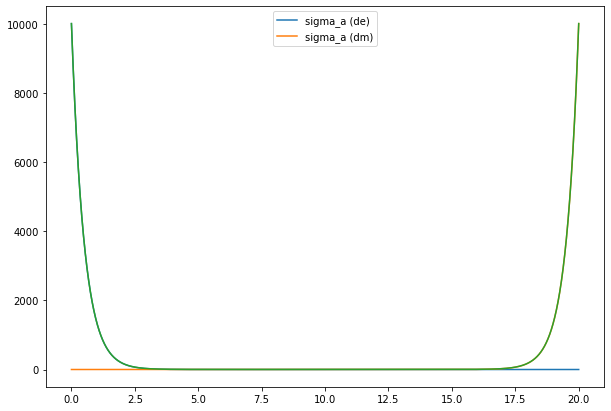

In [4]:
# this shows how sigma_a (de/dm), the variance along the long (omega_a) axis, changes in the a-de and a-dm planes respectively
# should rapidly go from very large to small then be roughly constant for a while in the a-de plane, and vice versa in the a-dm plane
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(0, 20, int(1e4)), neg_exponential(np.linspace(0, 20, int(1e4)), a=10000., b=2., c=1.5, d=0), label = 'sigma_a (de)')
plt.plot(np.linspace(0, 20, int(1e4)), neg_exponential(np.linspace(0, 20, int(1e4)), a=10000., b=-2., c=1.5, d=-20), label = 'sigma_a (dm)')
plt.plot(np.linspace(0, 20, int(1e4)), neg_exponential(np.linspace(0, 20, int(1e4)), a=10000., b=2., c=1.5, d=0) + neg_exponential(np.linspace(0, 20, int(1e4)), a=10000., b=-2., c=1.5, d=-20))
plt.legend()

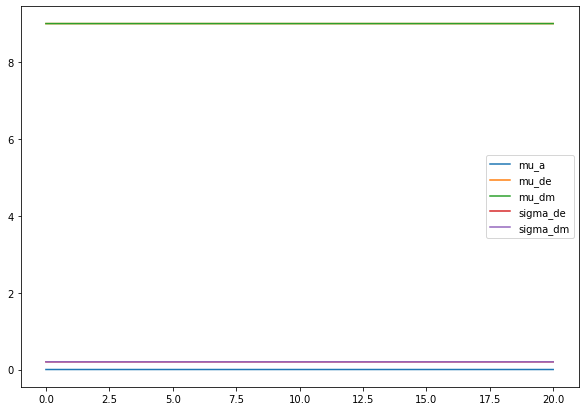

In [5]:
# this shows how the means mu_a, mu_de, mu_dm change with mass in: both the a-de and a-dm, the a-de, and the a-dm 
# planes respectively, as well as how sigma_de and sigma_dm (the variance along the short axis) changes in the 
# a-de and a-dm planes respectively
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=0, b=1.5, c=6, d=0), label = 'mu_a')  # mu_a
plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=0, b=1.5, c=6, d=9), label = 'mu_de')  # mu_de
plt.plot(np.linspace(0, 20, int(1e4)), sigmoid(np.linspace(0, 20, int(1e4)), a=0, b=1.5, c=6, d=9), label = 'mu_dm')  # mu_dm
plt.plot(np.linspace(0, 20, int(1e4)), neg_exponential(np.linspace(0, 20, int(1e4)), a=0., b=0., c=0.2, d=0.), label = 'sigma_de')
plt.plot(np.linspace(0, 20, int(1e4)), neg_exponential(np.linspace(0, 20, int(1e4)), a=0., b=0., c=0.2, d=0.), label = 'sigma_dm')
plt.legend()

Compute the function over some $4$-D hypercube:

In [6]:
npoints = 100

# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

testarr = np.zeros((npoints, npoints, npoints, npoints))
# testarr = np.zeros((npoints, npoints, npoints, npoints))
X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))
# X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
#                          np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))

for i in tqdm(range(0, len(X))):
    for j in range(0, len(Y)):
         for k in range(0, len(Z)):
                for l in range(0, len(W)):
                    testarr[i, j, k, l] = log_likelihood((X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l]))

# for i in range(0, len(X)):
#     for j in range(0, len(Y)):
#         for k in range(0, len(Z)):
#             for w in range (0, len(W)):
#                 testarr[i, j, k, w] = log_likelihood((X[i, j, k, w], Y[i, j, k, w], Z[i, j, k, w], W[i, j, k, w]))

100%|██████████| 100/100 [1:03:54<00:00, 38.35s/it]


Plotting:

<IPython.core.display.Javascript object>


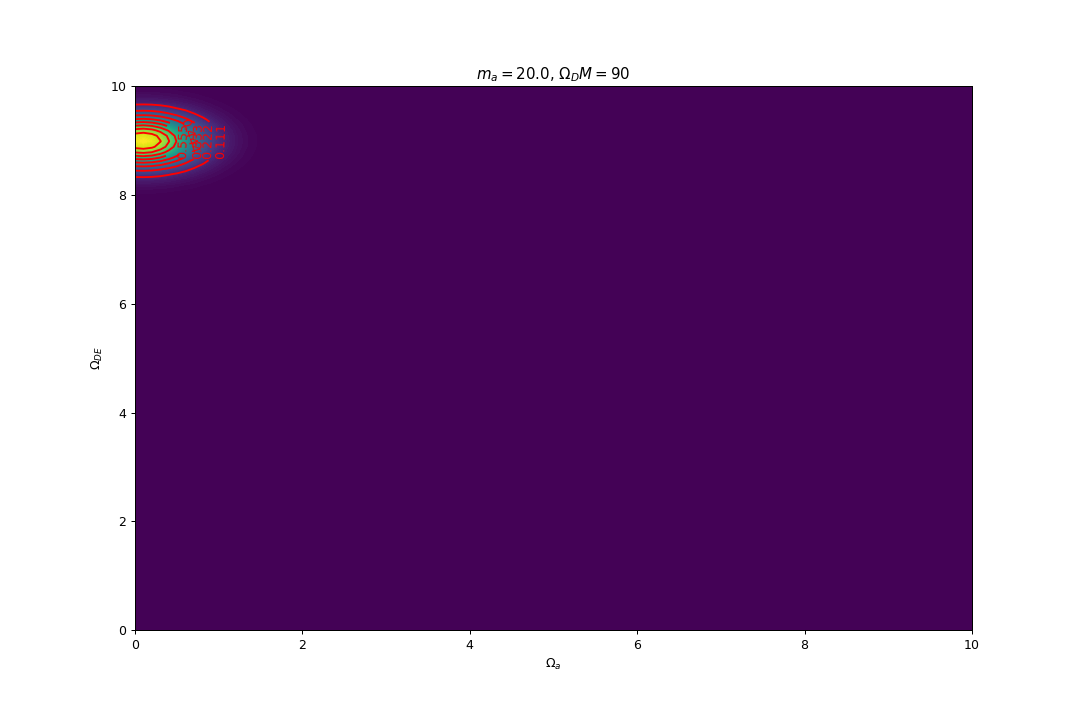

In [111]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# ws
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_dm constant, vary m_a
omega_dm = 90

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_dm_ind=omega_dm):
    ax.clear()
    arr = testarr[:, :, omega_dm_ind, w_ind]  # hold omega_dm constant
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    # cb = plt.colorbar()
    # cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)
    
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    # fig2 = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    # plt.clabel(fig2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DE}$') # x is omega_a, y is omega_de, z is m_a
    #    plt.tight_layout()
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DM = ${omega_dm}') # x is omega_a, y is omega_de, z is m_a
    
# plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
# cb = plt.colorbar()
# cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

# fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(fig, inline=True, fontsize=10)
# plt.xlabel('X'), plt.ylabel('Y')
# plt.tight_layout()
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

In [2]:
import scipy

scipy.integrate.dblquad()

TypeError: dblquad() missing 5 required positional arguments: 'func', 'a', 'b', 'gfun', and 'hfun'

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


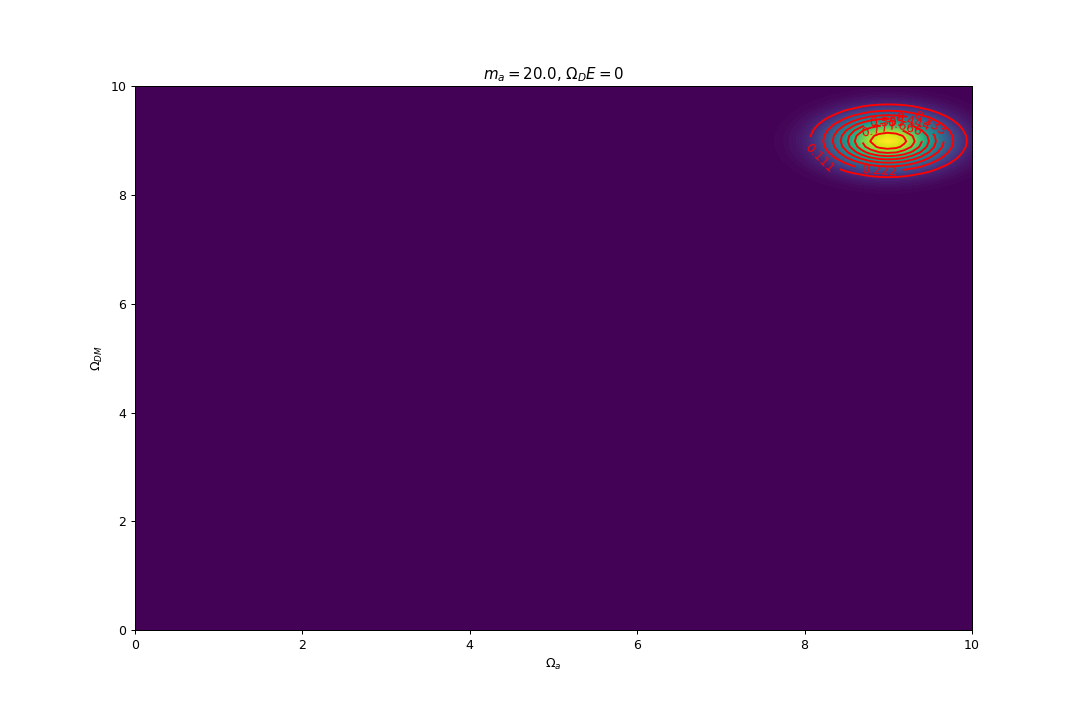

In [8]:
%matplotlib notebook
%matplotlib notebook

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_dm constant, vary m_a
omega_de = 0

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_de_ind=omega_de):
    ax.clear()
    arr = testarr[:, omega_de_ind, :, w_ind]  # hold omega_dm constant
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    
    ax.contourf(X[:, :, 0, 0], Z[0, 0, :, :], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    # cb = plt.colorbar()
    # cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)
    
    ax2 = ax.contour(X[:, :, 0, 0], Z[0, 0, :, :], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    # fig2 = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    # plt.clabel(fig2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_de, z is m_a
    #    plt.tight_layout()
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DE = ${omega_de}') # x is omega_a, y is omega_de, z is m_a
    
# plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
# cb = plt.colorbar()
# cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

# fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(fig, inline=True, fontsize=10)
# plt.xlabel('X'), plt.ylabel('Y')
# plt.tight_layout()
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_de.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

Now integrate over $\Omega_{DE}$ from $0$ to $10$ ($-\infty$ to $\infty$ should be the same...) and then $\Omega_{DM} from $0$ to $10$:

In [53]:
for i in tqdm(range(0, len(X))):
    for j in range(0, len(W)):
        for k in range(0, len(Z)):
            print(Z[i, 0, k, j], W[i, 0, k, j], X[0, i, k, j])

  0%|          | 0/100 [00:00<?, ?it/s]

0.0 0.0 0.0
0.10101010101010101 0.0 0.0
0.20202020202020202 0.0 0.0
0.30303030303030304 0.0 0.0
0.40404040404040403 0.0 0.0
0.5050505050505051 0.0 0.0
0.6060606060606061 0.0 0.0
0.7070707070707071 0.0 0.0
0.8080808080808081 0.0 0.0
0.9090909090909091 0.0 0.0
1.0101010101010102 0.0 0.0
1.1111111111111112 0.0 0.0
1.2121212121212122 0.0 0.0
1.3131313131313131 0.0 0.0
1.4141414141414141 0.0 0.0
1.5151515151515151 0.0 0.0
1.6161616161616161 0.0 0.0
1.7171717171717171 0.0 0.0
1.8181818181818181 0.0 0.0
1.9191919191919191 0.0 0.0
2.0202020202020203 0.0 0.0
2.121212121212121 0.0 0.0
2.2222222222222223 0.0 0.0
2.323232323232323 0.0 0.0
2.4242424242424243 0.0 0.0
2.525252525252525 0.0 0.0
2.6262626262626263 0.0 0.0
2.727272727272727 0.0 0.0
2.8282828282828283 0.0 0.0
2.929292929292929 0.0 0.0
3.0303030303030303 0.0 0.0
3.131313131313131 0.0 0.0
3.2323232323232323 0.0 0.0
3.3333333333333335 0.0 0.0
3.4343434343434343 0.0 0.0
3.5353535353535355 0.0 0.0
3.6363636363636362 0.0 0.0
3.7373737373737375

5.555555555555555 2.8282828282828283 0.0
5.656565656565657 2.8282828282828283 0.0
5.757575757575758 2.8282828282828283 0.0
5.858585858585858 2.8282828282828283 0.0
5.959595959595959 2.8282828282828283 0.0
6.0606060606060606 2.8282828282828283 0.0
6.161616161616162 2.8282828282828283 0.0
6.262626262626262 2.8282828282828283 0.0
6.363636363636363 2.8282828282828283 0.0
6.4646464646464645 2.8282828282828283 0.0
6.565656565656566 2.8282828282828283 0.0
6.666666666666667 2.8282828282828283 0.0
6.767676767676767 2.8282828282828283 0.0
6.8686868686868685 2.8282828282828283 0.0
6.96969696969697 2.8282828282828283 0.0
7.070707070707071 2.8282828282828283 0.0
7.171717171717171 2.8282828282828283 0.0
7.2727272727272725 2.8282828282828283 0.0
7.373737373737374 2.8282828282828283 0.0
7.474747474747475 2.8282828282828283 0.0
7.575757575757575 2.8282828282828283 0.0
7.6767676767676765 2.8282828282828283 0.0
7.777777777777778 2.8282828282828283 0.0
7.878787878787879 2.8282828282828283 0.0
7.9797979797

5.555555555555555 5.858585858585858 0.0
5.656565656565657 5.858585858585858 0.0
5.757575757575758 5.858585858585858 0.0
5.858585858585858 5.858585858585858 0.0
5.959595959595959 5.858585858585858 0.0
6.0606060606060606 5.858585858585858 0.0
6.161616161616162 5.858585858585858 0.0
6.262626262626262 5.858585858585858 0.0
6.363636363636363 5.858585858585858 0.0
6.4646464646464645 5.858585858585858 0.0
6.565656565656566 5.858585858585858 0.0
6.666666666666667 5.858585858585858 0.0
6.767676767676767 5.858585858585858 0.0
6.8686868686868685 5.858585858585858 0.0
6.96969696969697 5.858585858585858 0.0
7.070707070707071 5.858585858585858 0.0
7.171717171717171 5.858585858585858 0.0
7.2727272727272725 5.858585858585858 0.0
7.373737373737374 5.858585858585858 0.0
7.474747474747475 5.858585858585858 0.0
7.575757575757575 5.858585858585858 0.0
7.6767676767676765 5.858585858585858 0.0
7.777777777777778 5.858585858585858 0.0
7.878787878787879 5.858585858585858 0.0
7.979797979797979 5.858585858585858 

3.7373737373737375 8.686868686868687 0.0
3.8383838383838382 8.686868686868687 0.0
3.9393939393939394 8.686868686868687 0.0
4.040404040404041 8.686868686868687 0.0
4.141414141414141 8.686868686868687 0.0
4.242424242424242 8.686868686868687 0.0
4.343434343434343 8.686868686868687 0.0
4.444444444444445 8.686868686868687 0.0
4.545454545454545 8.686868686868687 0.0
4.646464646464646 8.686868686868687 0.0
4.747474747474747 8.686868686868687 0.0
4.848484848484849 8.686868686868687 0.0
4.94949494949495 8.686868686868687 0.0
5.05050505050505 8.686868686868687 0.0
5.151515151515151 8.686868686868687 0.0
5.252525252525253 8.686868686868687 0.0
5.353535353535354 8.686868686868687 0.0
5.454545454545454 8.686868686868687 0.0
5.555555555555555 8.686868686868687 0.0
5.656565656565657 8.686868686868687 0.0
5.757575757575758 8.686868686868687 0.0
5.858585858585858 8.686868686868687 0.0
5.959595959595959 8.686868686868687 0.0
6.0606060606060606 8.686868686868687 0.0
6.161616161616162 8.686868686868687 0.

8.88888888888889 11.515151515151516 0.0
8.98989898989899 11.515151515151516 0.0
9.09090909090909 11.515151515151516 0.0
9.191919191919192 11.515151515151516 0.0
9.292929292929292 11.515151515151516 0.0
9.393939393939394 11.515151515151516 0.0
9.494949494949495 11.515151515151516 0.0
9.595959595959595 11.515151515151516 0.0
9.696969696969697 11.515151515151516 0.0
9.797979797979798 11.515151515151516 0.0
9.8989898989899 11.515151515151516 0.0
10.0 11.515151515151516 0.0
0.0 11.717171717171716 0.0
0.10101010101010101 11.717171717171716 0.0
0.20202020202020202 11.717171717171716 0.0
0.30303030303030304 11.717171717171716 0.0
0.40404040404040403 11.717171717171716 0.0
0.5050505050505051 11.717171717171716 0.0
0.6060606060606061 11.717171717171716 0.0
0.7070707070707071 11.717171717171716 0.0
0.8080808080808081 11.717171717171716 0.0
0.9090909090909091 11.717171717171716 0.0
1.0101010101010102 11.717171717171716 0.0
1.1111111111111112 11.717171717171716 0.0
1.2121212121212122 11.71717171717

0.20202020202020202 14.747474747474747 0.0
0.30303030303030304 14.747474747474747 0.0
0.40404040404040403 14.747474747474747 0.0
0.5050505050505051 14.747474747474747 0.0
0.6060606060606061 14.747474747474747 0.0
0.7070707070707071 14.747474747474747 0.0
0.8080808080808081 14.747474747474747 0.0
0.9090909090909091 14.747474747474747 0.0
1.0101010101010102 14.747474747474747 0.0
1.1111111111111112 14.747474747474747 0.0
1.2121212121212122 14.747474747474747 0.0
1.3131313131313131 14.747474747474747 0.0
1.4141414141414141 14.747474747474747 0.0
1.5151515151515151 14.747474747474747 0.0
1.6161616161616161 14.747474747474747 0.0
1.7171717171717171 14.747474747474747 0.0
1.8181818181818181 14.747474747474747 0.0
1.9191919191919191 14.747474747474747 0.0
2.0202020202020203 14.747474747474747 0.0
2.121212121212121 14.747474747474747 0.0
2.2222222222222223 14.747474747474747 0.0
2.323232323232323 14.747474747474747 0.0
2.4242424242424243 14.747474747474747 0.0
2.525252525252525 14.747474747474

  1%|          | 1/100 [00:01<02:20,  1.42s/it]

3.2323232323232323 17.77777777777778 0.0
3.3333333333333335 17.77777777777778 0.0
3.4343434343434343 17.77777777777778 0.0
3.5353535353535355 17.77777777777778 0.0
3.6363636363636362 17.77777777777778 0.0
3.7373737373737375 17.77777777777778 0.0
3.8383838383838382 17.77777777777778 0.0
3.9393939393939394 17.77777777777778 0.0
4.040404040404041 17.77777777777778 0.0
4.141414141414141 17.77777777777778 0.0
4.242424242424242 17.77777777777778 0.0
4.343434343434343 17.77777777777778 0.0
4.444444444444445 17.77777777777778 0.0
4.545454545454545 17.77777777777778 0.0
4.646464646464646 17.77777777777778 0.0
4.747474747474747 17.77777777777778 0.0
4.848484848484849 17.77777777777778 0.0
4.94949494949495 17.77777777777778 0.0
5.05050505050505 17.77777777777778 0.0
5.151515151515151 17.77777777777778 0.0
5.252525252525253 17.77777777777778 0.0
5.353535353535354 17.77777777777778 0.0
5.454545454545454 17.77777777777778 0.0
5.555555555555555 17.77777777777778 0.0
5.656565656565657 17.7777777777777

6.4646464646464645 0.0 0.10101010101010101
6.565656565656566 0.0 0.10101010101010101
6.666666666666667 0.0 0.10101010101010101
6.767676767676767 0.0 0.10101010101010101
6.8686868686868685 0.0 0.10101010101010101
6.96969696969697 0.0 0.10101010101010101
7.070707070707071 0.0 0.10101010101010101
7.171717171717171 0.0 0.10101010101010101
7.2727272727272725 0.0 0.10101010101010101
7.373737373737374 0.0 0.10101010101010101
7.474747474747475 0.0 0.10101010101010101
7.575757575757575 0.0 0.10101010101010101
7.6767676767676765 0.0 0.10101010101010101
7.777777777777778 0.0 0.10101010101010101
7.878787878787879 0.0 0.10101010101010101
7.979797979797979 0.0 0.10101010101010101
8.080808080808081 0.0 0.10101010101010101
8.181818181818182 0.0 0.10101010101010101
8.282828282828282 0.0 0.10101010101010101
8.383838383838384 0.0 0.10101010101010101
8.484848484848484 0.0 0.10101010101010101
8.585858585858587 0.0 0.10101010101010101
8.686868686868687 0.0 0.10101010101010101
8.787878787878787 0.0 0.1010101

1.3131313131313131 2.8282828282828283 0.10101010101010101
1.4141414141414141 2.8282828282828283 0.10101010101010101
1.5151515151515151 2.8282828282828283 0.10101010101010101
1.6161616161616161 2.8282828282828283 0.10101010101010101
1.7171717171717171 2.8282828282828283 0.10101010101010101
1.8181818181818181 2.8282828282828283 0.10101010101010101
1.9191919191919191 2.8282828282828283 0.10101010101010101
2.0202020202020203 2.8282828282828283 0.10101010101010101
2.121212121212121 2.8282828282828283 0.10101010101010101
2.2222222222222223 2.8282828282828283 0.10101010101010101
2.323232323232323 2.8282828282828283 0.10101010101010101
2.4242424242424243 2.8282828282828283 0.10101010101010101
2.525252525252525 2.8282828282828283 0.10101010101010101
2.6262626262626263 2.8282828282828283 0.10101010101010101
2.727272727272727 2.8282828282828283 0.10101010101010101
2.8282828282828283 2.8282828282828283 0.10101010101010101
2.929292929292929 2.8282828282828283 0.10101010101010101
3.0303030303030303 

5.353535353535354 5.858585858585858 0.10101010101010101
5.454545454545454 5.858585858585858 0.10101010101010101
5.555555555555555 5.858585858585858 0.10101010101010101
5.656565656565657 5.858585858585858 0.10101010101010101
5.757575757575758 5.858585858585858 0.10101010101010101
5.858585858585858 5.858585858585858 0.10101010101010101
5.959595959595959 5.858585858585858 0.10101010101010101
6.0606060606060606 5.858585858585858 0.10101010101010101
6.161616161616162 5.858585858585858 0.10101010101010101
6.262626262626262 5.858585858585858 0.10101010101010101
6.363636363636363 5.858585858585858 0.10101010101010101
6.4646464646464645 5.858585858585858 0.10101010101010101
6.565656565656566 5.858585858585858 0.10101010101010101
6.666666666666667 5.858585858585858 0.10101010101010101
6.767676767676767 5.858585858585858 0.10101010101010101
6.8686868686868685 5.858585858585858 0.10101010101010101
6.96969696969697 5.858585858585858 0.10101010101010101
7.070707070707071 5.858585858585858 0.10101010

1.8181818181818181 8.686868686868687 0.10101010101010101
1.9191919191919191 8.686868686868687 0.10101010101010101
2.0202020202020203 8.686868686868687 0.10101010101010101
2.121212121212121 8.686868686868687 0.10101010101010101
2.2222222222222223 8.686868686868687 0.10101010101010101
2.323232323232323 8.686868686868687 0.10101010101010101
2.4242424242424243 8.686868686868687 0.10101010101010101
2.525252525252525 8.686868686868687 0.10101010101010101
2.6262626262626263 8.686868686868687 0.10101010101010101
2.727272727272727 8.686868686868687 0.10101010101010101
2.8282828282828283 8.686868686868687 0.10101010101010101
2.929292929292929 8.686868686868687 0.10101010101010101
3.0303030303030303 8.686868686868687 0.10101010101010101
3.131313131313131 8.686868686868687 0.10101010101010101
3.2323232323232323 8.686868686868687 0.10101010101010101
3.3333333333333335 8.686868686868687 0.10101010101010101
3.4343434343434343 8.686868686868687 0.10101010101010101
3.5353535353535355 8.686868686868687 

  1%|          | 1/100 [00:02<03:50,  2.33s/it]

11.11111111111111 0.10101010101010101
1.7171717171717171 11.11111111111111 0.10101010101010101
1.8181818181818181 11.11111111111111 0.10101010101010101
1.9191919191919191 11.11111111111111 0.10101010101010101
2.0202020202020203 11.11111111111111 0.10101010101010101
2.121212121212121 11.11111111111111 0.10101010101010101
2.2222222222222223 11.11111111111111 0.10101010101010101
2.323232323232323 11.11111111111111 0.10101010101010101
2.4242424242424243 11.11111111111111 0.10101010101010101
2.525252525252525 11.11111111111111 0.10101010101010101
2.6262626262626263 11.11111111111111 0.10101010101010101
2.727272727272727 11.11111111111111 0.10101010101010101
2.8282828282828283 11.11111111111111 0.10101010101010101
2.929292929292929 11.11111111111111 0.10101010101010101
3.0303030303030303 11.11111111111111 0.10101010101010101
3.131313131313131 11.11111111111111 0.10101010101010101
3.2323232323232323 11.11111111111111 0.10101010101010101
3.3333333333333335 11.11111111111111 0.10101010101010101

KeyboardInterrupt: 

In [100]:
for i in tqdm(range(0, len(X))):
    for j in range(0, len(W)):
        for k in range(0, len(Z)):
            print(X[i, k, j, 0], Z[i, k, j, 0], W[i, 0, k, j])

  0%|          | 0/100 [00:00<?, ?it/s]

0.0 0.0 0.0
0.10101010101010101 0.0 0.0
0.20202020202020202 0.0 0.0
0.30303030303030304 0.0 0.0
0.40404040404040403 0.0 0.0
0.5050505050505051 0.0 0.0
0.6060606060606061 0.0 0.0
0.7070707070707071 0.0 0.0
0.8080808080808081 0.0 0.0
0.9090909090909091 0.0 0.0
1.0101010101010102 0.0 0.0
1.1111111111111112 0.0 0.0
1.2121212121212122 0.0 0.0
1.3131313131313131 0.0 0.0
1.4141414141414141 0.0 0.0
1.5151515151515151 0.0 0.0
1.6161616161616161 0.0 0.0
1.7171717171717171 0.0 0.0
1.8181818181818181 0.0 0.0
1.9191919191919191 0.0 0.0
2.0202020202020203 0.0 0.0
2.121212121212121 0.0 0.0
2.2222222222222223 0.0 0.0
2.323232323232323 0.0 0.0
2.4242424242424243 0.0 0.0
2.525252525252525 0.0 0.0
2.6262626262626263 0.0 0.0
2.727272727272727 0.0 0.0
2.8282828282828283 0.0 0.0
2.929292929292929 0.0 0.0
3.0303030303030303 0.0 0.0
3.131313131313131 0.0 0.0
3.2323232323232323 0.0 0.0
3.3333333333333335 0.0 0.0
3.4343434343434343 0.0 0.0
3.5353535353535355 0.0 0.0
3.6363636363636362 0.0 0.0
3.7373737373737375

9.8989898989899 1.5151515151515151 3.0303030303030303
10.0 1.5151515151515151 3.0303030303030303
0.0 1.6161616161616161 3.2323232323232323
0.10101010101010101 1.6161616161616161 3.2323232323232323
0.20202020202020202 1.6161616161616161 3.2323232323232323
0.30303030303030304 1.6161616161616161 3.2323232323232323
0.40404040404040403 1.6161616161616161 3.2323232323232323
0.5050505050505051 1.6161616161616161 3.2323232323232323
0.6060606060606061 1.6161616161616161 3.2323232323232323
0.7070707070707071 1.6161616161616161 3.2323232323232323
0.8080808080808081 1.6161616161616161 3.2323232323232323
0.9090909090909091 1.6161616161616161 3.2323232323232323
1.0101010101010102 1.6161616161616161 3.2323232323232323
1.1111111111111112 1.6161616161616161 3.2323232323232323
1.2121212121212122 1.6161616161616161 3.2323232323232323
1.3131313131313131 1.6161616161616161 3.2323232323232323
1.4141414141414141 1.6161616161616161 3.2323232323232323
1.5151515151515151 1.6161616161616161 3.2323232323232323
1.

3.9393939393939394 3.131313131313131 6.262626262626262
4.040404040404041 3.131313131313131 6.262626262626262
4.141414141414141 3.131313131313131 6.262626262626262
4.242424242424242 3.131313131313131 6.262626262626262
4.343434343434343 3.131313131313131 6.262626262626262
4.444444444444445 3.131313131313131 6.262626262626262
4.545454545454545 3.131313131313131 6.262626262626262
4.646464646464646 3.131313131313131 6.262626262626262
4.747474747474747 3.131313131313131 6.262626262626262
4.848484848484849 3.131313131313131 6.262626262626262
4.94949494949495 3.131313131313131 6.262626262626262
5.05050505050505 3.131313131313131 6.262626262626262
5.151515151515151 3.131313131313131 6.262626262626262
5.252525252525253 3.131313131313131 6.262626262626262
5.353535353535354 3.131313131313131 6.262626262626262
5.454545454545454 3.131313131313131 6.262626262626262
5.555555555555555 3.131313131313131 6.262626262626262
5.656565656565657 3.131313131313131 6.262626262626262
5.757575757575758 3.131313131

7.070707070707071 4.444444444444445 8.88888888888889
7.171717171717171 4.444444444444445 8.88888888888889
7.2727272727272725 4.444444444444445 8.88888888888889
7.373737373737374 4.444444444444445 8.88888888888889
7.474747474747475 4.444444444444445 8.88888888888889
7.575757575757575 4.444444444444445 8.88888888888889
7.6767676767676765 4.444444444444445 8.88888888888889
7.777777777777778 4.444444444444445 8.88888888888889
7.878787878787879 4.444444444444445 8.88888888888889
7.979797979797979 4.444444444444445 8.88888888888889
8.080808080808081 4.444444444444445 8.88888888888889
8.181818181818182 4.444444444444445 8.88888888888889
8.282828282828282 4.444444444444445 8.88888888888889
8.383838383838384 4.444444444444445 8.88888888888889
8.484848484848484 4.444444444444445 8.88888888888889
8.585858585858587 4.444444444444445 8.88888888888889
8.686868686868687 4.444444444444445 8.88888888888889
8.787878787878787 4.444444444444445 8.88888888888889
8.88888888888889 4.444444444444445 8.8888888

4.444444444444445 5.858585858585858 11.717171717171716
4.545454545454545 5.858585858585858 11.717171717171716
4.646464646464646 5.858585858585858 11.717171717171716
4.747474747474747 5.858585858585858 11.717171717171716
4.848484848484849 5.858585858585858 11.717171717171716
4.94949494949495 5.858585858585858 11.717171717171716
5.05050505050505 5.858585858585858 11.717171717171716
5.151515151515151 5.858585858585858 11.717171717171716
5.252525252525253 5.858585858585858 11.717171717171716
5.353535353535354 5.858585858585858 11.717171717171716
5.454545454545454 5.858585858585858 11.717171717171716
5.555555555555555 5.858585858585858 11.717171717171716
5.656565656565657 5.858585858585858 11.717171717171716
5.757575757575758 5.858585858585858 11.717171717171716
5.858585858585858 5.858585858585858 11.717171717171716
5.959595959595959 5.858585858585858 11.717171717171716
6.0606060606060606 5.858585858585858 11.717171717171716
6.161616161616162 5.858585858585858 11.717171717171716
6.262626262

0.40404040404040403 7.070707070707071 14.141414141414142
0.5050505050505051 7.070707070707071 14.141414141414142
0.6060606060606061 7.070707070707071 14.141414141414142
0.7070707070707071 7.070707070707071 14.141414141414142
0.8080808080808081 7.070707070707071 14.141414141414142
0.9090909090909091 7.070707070707071 14.141414141414142
1.0101010101010102 7.070707070707071 14.141414141414142
1.1111111111111112 7.070707070707071 14.141414141414142
1.2121212121212122 7.070707070707071 14.141414141414142
1.3131313131313131 7.070707070707071 14.141414141414142
1.4141414141414141 7.070707070707071 14.141414141414142
1.5151515151515151 7.070707070707071 14.141414141414142
1.6161616161616161 7.070707070707071 14.141414141414142
1.7171717171717171 7.070707070707071 14.141414141414142
1.8181818181818181 7.070707070707071 14.141414141414142
1.9191919191919191 7.070707070707071 14.141414141414142
2.0202020202020203 7.070707070707071 14.141414141414142
2.121212121212121 7.070707070707071 14.14141414

4.444444444444445 8.484848484848484 16.96969696969697
4.545454545454545 8.484848484848484 16.96969696969697
4.646464646464646 8.484848484848484 16.96969696969697
4.747474747474747 8.484848484848484 16.96969696969697
4.848484848484849 8.484848484848484 16.96969696969697
4.94949494949495 8.484848484848484 16.96969696969697
5.05050505050505 8.484848484848484 16.96969696969697
5.151515151515151 8.484848484848484 16.96969696969697
5.252525252525253 8.484848484848484 16.96969696969697
5.353535353535354 8.484848484848484 16.96969696969697
5.454545454545454 8.484848484848484 16.96969696969697
5.555555555555555 8.484848484848484 16.96969696969697
5.656565656565657 8.484848484848484 16.96969696969697
5.757575757575758 8.484848484848484 16.96969696969697
5.858585858585858 8.484848484848484 16.96969696969697
5.959595959595959 8.484848484848484 16.96969696969697
6.0606060606060606 8.484848484848484 16.96969696969697
6.161616161616162 8.484848484848484 16.96969696969697
6.262626262626262 8.484848484

  1%|          | 1/100 [00:01<02:23,  1.45s/it]

9.8989898989899 19.7979797979798
7.070707070707071 9.8989898989899 19.7979797979798
7.171717171717171 9.8989898989899 19.7979797979798
7.2727272727272725 9.8989898989899 19.7979797979798
7.373737373737374 9.8989898989899 19.7979797979798
7.474747474747475 9.8989898989899 19.7979797979798
7.575757575757575 9.8989898989899 19.7979797979798
7.6767676767676765 9.8989898989899 19.7979797979798
7.777777777777778 9.8989898989899 19.7979797979798
7.878787878787879 9.8989898989899 19.7979797979798
7.979797979797979 9.8989898989899 19.7979797979798
8.080808080808081 9.8989898989899 19.7979797979798
8.181818181818182 9.8989898989899 19.7979797979798
8.282828282828282 9.8989898989899 19.7979797979798
8.383838383838384 9.8989898989899 19.7979797979798
8.484848484848484 9.8989898989899 19.7979797979798
8.585858585858587 9.8989898989899 19.7979797979798
8.686868686868687 9.8989898989899 19.7979797979798
8.787878787878787 9.8989898989899 19.7979797979798
8.88888888888889 9.8989898989899 19.79797979797

  1%|          | 1/100 [00:01<02:54,  1.76s/it]

2.4242424242424243
6.4646464646464645 1.2121212121212122 2.4242424242424243
6.565656565656566 1.2121212121212122 2.4242424242424243
6.666666666666667 1.2121212121212122 2.4242424242424243
6.767676767676767 1.2121212121212122 2.4242424242424243
6.8686868686868685 1.2121212121212122 2.4242424242424243
6.96969696969697 1.2121212121212122 2.4242424242424243
7.070707070707071 1.2121212121212122 2.4242424242424243
7.171717171717171 1.2121212121212122 2.4242424242424243
7.2727272727272725 1.2121212121212122 2.4242424242424243
7.373737373737374 1.2121212121212122 2.4242424242424243
7.474747474747475 1.2121212121212122 2.4242424242424243
7.575757575757575 1.2121212121212122 2.4242424242424243
7.6767676767676765 1.2121212121212122 2.4242424242424243
7.777777777777778 1.2121212121212122 2.4242424242424243
7.878787878787879 1.2121212121212122 2.4242424242424243
7.979797979797979 1.2121212121212122 2.4242424242424243
8.080808080808081 1.2121212121212122 2.4242424242424243
8.181818181818182 1.212121

KeyboardInterrupt: 

In [99]:
W[0, :, :, :]

array([[[ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        ...,
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ]],

       [[ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        ...,
        [ 0.       ,  0.2020202,  0.4040404, ..., 19.5959596,
         19.7979798, 20.       ],
        [ 0.

In [51]:
# %matplotlib auto
# plt.ioff()
import scipy

# integrate over y and then z
integrated_likelihood = np.zeros((len(X), len(W)))

# x is omega_a, y is omega_de, z is omega_dm, w is m_a

for i in tqdm(range(0, len(X))):
    for j in range(0, len(W)):
        for k in range(0, len(Z)):
            integrated_likelihood_de = scipy.integrate.quad(lambda omega_de, omega_a, omega_dm, m_a: 
                                                            log_likelihood((omega_a, omega_de, omega_dm, m_a)), 
                                                            a=0, b=10, args=(X[0, i, j], Z[0, i, j], W[0, i, j])
        
                                                            
                                                            
                                                            
                                                            
                                                            
                                                            
                                                            integrated_likelihood[i, j] = scipy.integrate.quad(lambda omega_de, m_a, omega_a: 
                                                           log_likelihood((omega_a, omega_de, m_a)), 
                                                           a=0, b=10, args=(Z[0, i, j], X[0, i, j]))[0]

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


In [9]:
X[0, i, j]

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.])

And plot it to see if it matches the u-plot:

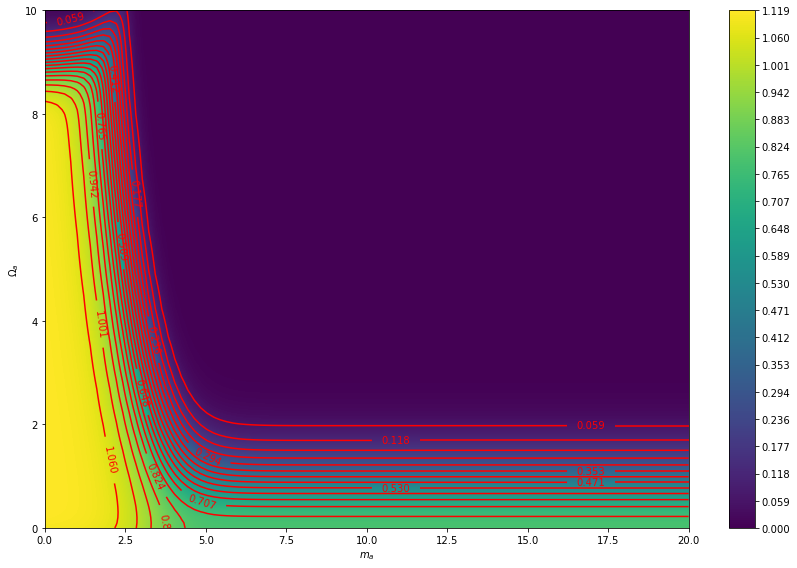

In [52]:
npoints = 500

# min and max for the contours
contour_min = np.min(integrated_likelihood)
contour_max = np.max(integrated_likelihood)

integrated_Z, integrated_X = Z[0], X[0]  # these need to be formatted in the right way

# plot
plt.figure(figsize = (12, 8))
plt.contourf(integrated_Z, integrated_X, integrated_likelihood, levels=np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')

# CONTOURS
fig = plt.contour(integrated_Z, integrated_X, integrated_likelihood, levels=np.linspace(contour_min, contour_max, 20), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

# save
# plt.savefig('integrated_3d_u_function.png', fmt='png')